## **Implementando GAN desde cero para generación de dígitos a partir del dataset MNIST Digit**

Se importan librerías y se generan 2 funciones para crear el modelo del "Generador" y el modelo del "Discriminador".

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
## define a function for the generator:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"
def make_generator_network(
		input_size=20,
		num_hidden_layers=1,
		num_hidden_units=100,
		num_output_units=784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}',
		  nn.Linear(input_size, num_output_units))
  model.add_module('tanh_g', nn.Tanh())
  return model

## define a function for the discriminator:
def make_discriminator_network(
		input_size,
		num_hidden_layers=1,
		num_hidden_units=100,
		num_output_units=1):
	model = nn.Sequential()
	for i in range(num_hidden_layers):
		model.add_module(
			f'fc_d{i}',
			nn.Linear(input_size, num_hidden_units, bias=False)
			)
		model.add_module(f'relu_d{i}', nn.LeakyReLU())
		model.add_module('dropout', nn.Dropout(p=0.5))
		input_size = num_hidden_units
	model.add_module(f'fc_d{num_hidden_layers}',
			nn.Linear(input_size, num_output_units))
	model.add_module('sigmoid', nn.Sigmoid())
	return model


Se configuran los Hiperparámetros y se llaman a las funciones anteriores para crear los modelos

In [13]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)
gen_model = make_generator_network(
  input_size=z_size,
  num_hidden_layers=gen_hidden_layers,
  num_hidden_units=gen_hidden_size,
  num_output_units=np.prod(image_size)
)
print(gen_model)
disc_model = make_discriminator_network(
input_size=np.prod(image_size),
num_hidden_layers=disc_hidden_layers,
num_hidden_units=disc_hidden_size
)
print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Se importa el Dataset MNIST

In [14]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(
root=image_path, train=True,
transform=transform, download=True
)
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


Se define la función para crear el ruido "Z" con la posibilidad de elegir entre una distribución normal o uniforme.

In [15]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
     input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
      input_z = torch.randn(batch_size, z_size)
    return input_z

Se crea el ruido "Z" el cual será la entrada del generador(gen_model).

input_real se crea a partir del dataset.

d_proba_real es la salida del discriminador dada la entrada input_real

d_proba_fake es la salida del discriminador con la entrada "Falsa" (el ruido), es decir, la salida del generador.

In [16]:
from torch.utils.data import DataLoader
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'normal' # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)
d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)


input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


Se crean las variables y funciones necesarias para el entrenamiento

In [17]:
loss_fn = nn.BCELoss()
## Loss for the Generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')
## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6860
Discriminator Losses: Real 0.7479 Fake 0.7016


In [18]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
shuffle=True, drop_last=True)
gen_model = make_generator_network(
input_size=z_size,
num_hidden_layers=gen_hidden_layers,
num_hidden_units=gen_hidden_size,
num_output_units=np.prod(image_size)).to(device)
disc_model = make_discriminator_network(
input_size=np.prod(image_size),
num_hidden_layers=disc_hidden_layers,
num_hidden_units=disc_hidden_size).to(device)
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [19]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()
    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item(), d_proba_real.detach(), \
    d_proba_fake.detach()
 
 ## Train the generator
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device) 
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [21]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0
    
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
#Completo
#num_epochs = 100
num_epochs = 25

for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
       f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
       f' [D-Real: {all_d_real[-1]:.4f}'
       f' D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
    create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 0.8996/1.2579 [D-Real: 0.5601 D-Fake: 0.4386]
Epoch 002 | Avg Losses >> G/D 0.8671/1.2716 [D-Real: 0.5547 D-Fake: 0.4475]
Epoch 003 | Avg Losses >> G/D 0.8797/1.2691 [D-Real: 0.5565 D-Fake: 0.4429]
Epoch 004 | Avg Losses >> G/D 0.8449/1.2862 [D-Real: 0.5481 D-Fake: 0.4538]
Epoch 005 | Avg Losses >> G/D 0.8483/1.2917 [D-Real: 0.5457 D-Fake: 0.4533]
Epoch 006 | Avg Losses >> G/D 0.8416/1.2924 [D-Real: 0.5452 D-Fake: 0.4556]
Epoch 007 | Avg Losses >> G/D 0.8248/1.3081 [D-Real: 0.5376 D-Fake: 0.4597]
Epoch 008 | Avg Losses >> G/D 0.7648/1.3450 [D-Real: 0.5205 D-Fake: 0.4771]
Epoch 009 | Avg Losses >> G/D 0.7933/1.3330 [D-Real: 0.5268 D-Fake: 0.4709]
Epoch 010 | Avg Losses >> G/D 0.7871/1.3305 [D-Real: 0.5283 D-Fake: 0.4721]
Epoch 011 | Avg Losses >> G/D 0.7930/1.3164 [D-Real: 0.5339 D-Fake: 0.4672]
Epoch 012 | Avg Losses >> G/D 0.8371/1.2995 [D-Real: 0.5434 D-Fake: 0.4590]
Epoch 013 | Avg Losses >> G/D 0.8459/1.2909 [D-Real: 0.5467 D-Fake: 0.4552]
Epoch 014 | 

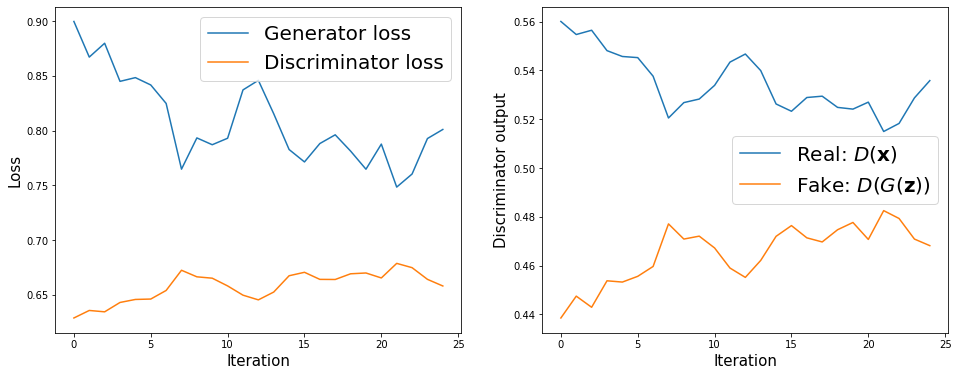

In [22]:
import itertools
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

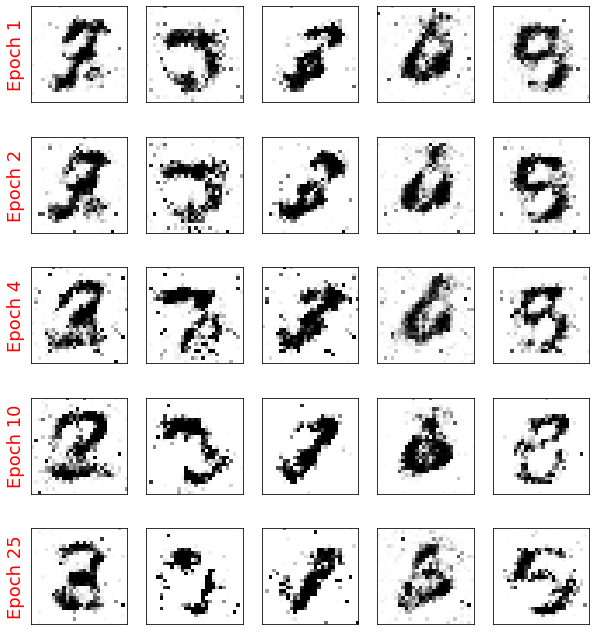

In [23]:
#Completo
#selected_epochs = [1, 2, 4, 10, 50, 100]
selected_epochs = [1, 2, 4, 10, 25]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}',
            rotation=90, size=18, color='red',
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes)
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
plt.show()